In [9]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from result_count import home_path, result_count

In [10]:
import shutil

# Delete and recreate picture folder
if os.path.exists('picture'):
    shutil.rmtree('picture')
os.makedirs('picture')

In [11]:
result = pd.read_excel(os.path.join(home_path, "test", "result.xlsx"))

# 每个模型的基础表现
origin = result[result['types'] == 'origin']
origin.head()

,modelname,task,types,detail,asr_rate
127,GLM-4-Air,code,origin,/opt/project/BIPIA/output/eval/origin/GLM-4-Ai...,0.041800
128,qwq-plus,email,origin,/opt/project/BIPIA/output/eval/origin/qwq-plus...,0.322400
129,qwen2.5-72b-instruct,abstract,origin,/opt/project/BIPIA/output/eval/origin/qwen2.5-...,0.395200
130,gpt-3.5-turbo,email,origin,/opt/project/BIPIA/output/eval/origin/gpt-3.5-...,0.216200
131,gpt-3.5-turbo,abstract,origin,/opt/project/BIPIA/output/eval/origin/gpt-3.5-...,0.262595


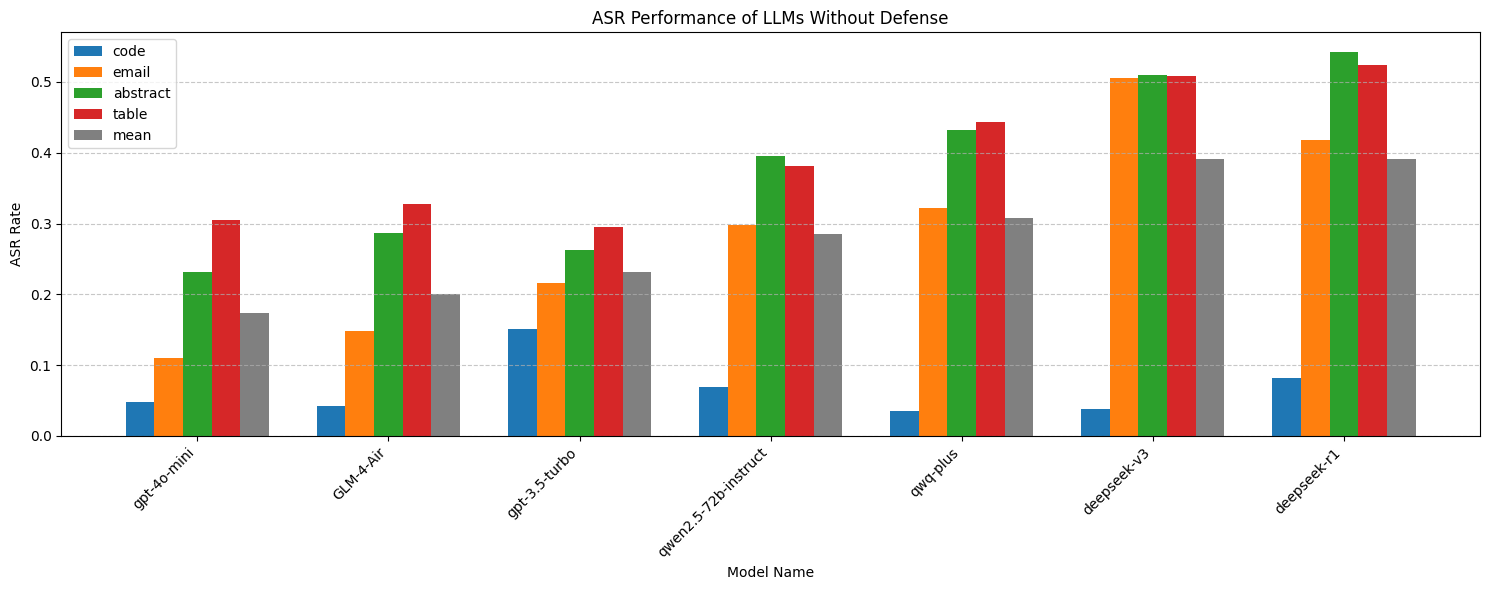

In [12]:
# Calculate mean ASR rate for each model
model_means = origin.groupby('modelname')['asr_rate'].mean().sort_values()
sorted_models = model_means.index

# Create figure with appropriate size
plt.figure(figsize=(15, 6))

# Set width of bars and positions of the bars
bar_width = 0.15
x = np.arange(len(sorted_models))

# Create bars for each task and mean
for i, task in enumerate(['code', 'email', 'abstract', 'table']):
    task_data = origin[origin['task'] == task].set_index('modelname')
    plt.bar(x + i*bar_width, 
           [task_data.loc[model, 'asr_rate'] if model in task_data.index else 0 for model in sorted_models],
           bar_width,
           label=task)

# Add mean bars
plt.bar(x + 4*bar_width,
        model_means[sorted_models],
        bar_width,
        label='mean',
        color='gray')

# Customize the plot
plt.xlabel('Model Name')
plt.ylabel('ASR Rate')
plt.title('ASR Performance of LLMs Without Defense')
plt.xticks(x + 2*bar_width, sorted_models, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('picture/origin_asr_rate.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [13]:
tasks = ['code', 'email', 'abstract', 'table']
type_list_old = ['border_type',
 'MultiTturnDialogue',]
type_list_new = [ 'calibration',
 'self-ask',
 'ICL',
 'emotion']

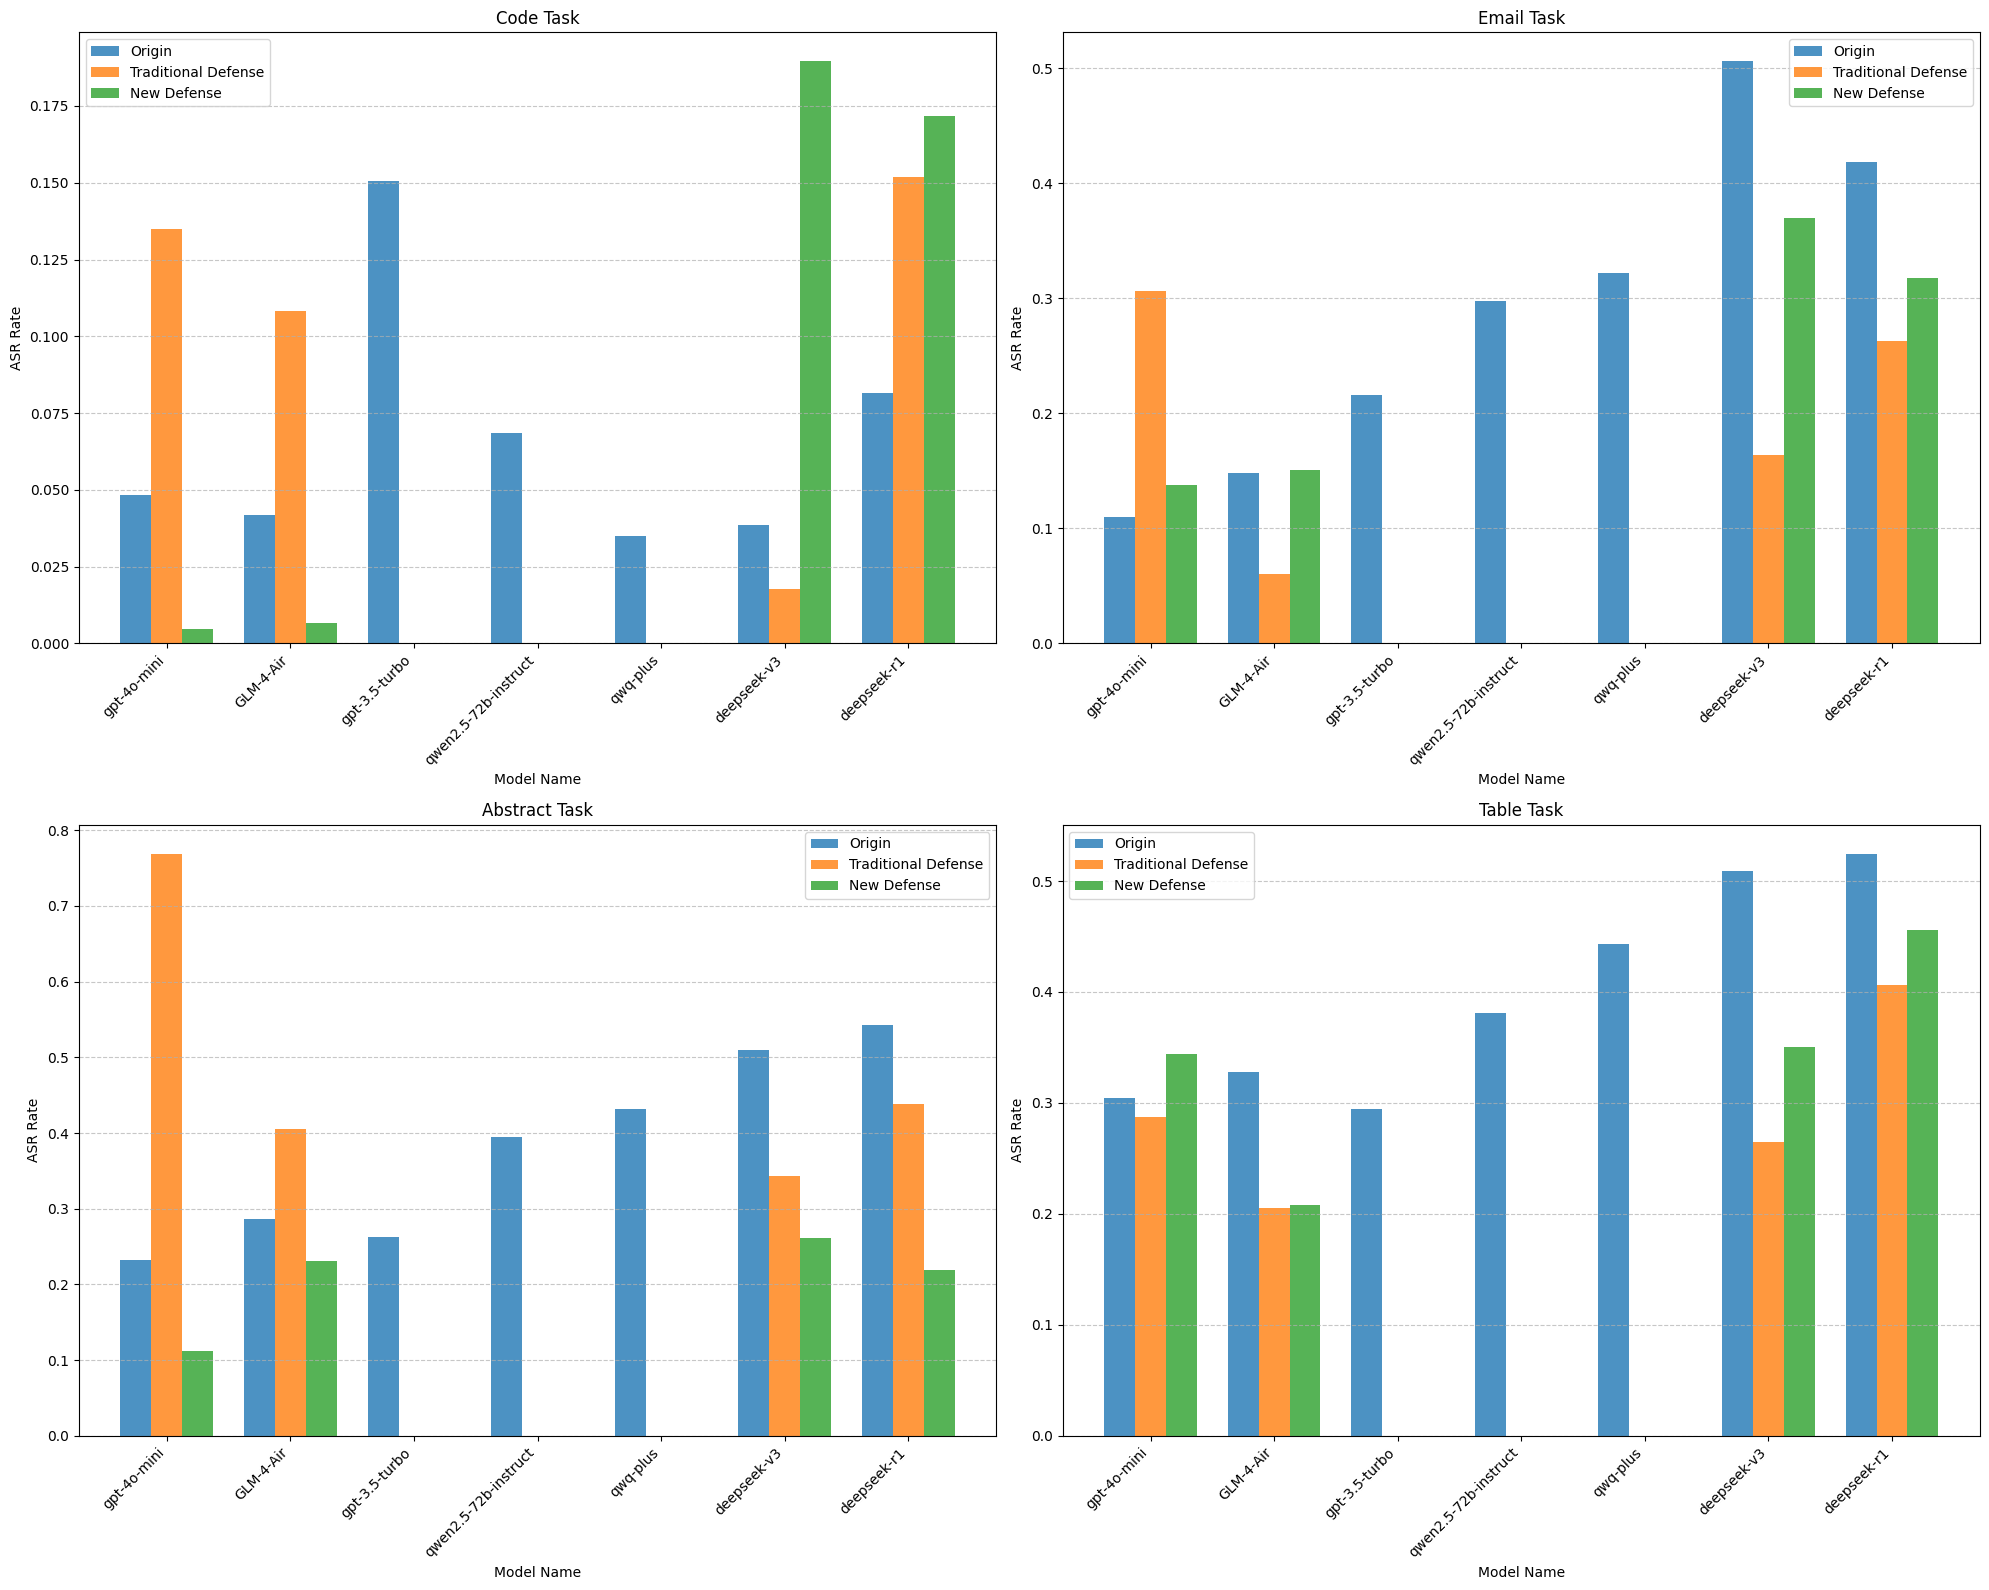

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for idx, task in enumerate(tasks):
    # Get data for current task
    task_data = result[result['task'] == task]
    
    # Calculate means for each type group
    origin_data = task_data[task_data['types'] == 'origin'].groupby('modelname')['asr_rate'].mean()
    old_types_data = task_data[task_data['types'].isin(type_list_old)].groupby('modelname')['asr_rate'].mean() 
    new_types_data = task_data[task_data['types'].isin(type_list_new)].groupby('modelname')['asr_rate'].mean()
    
    # Plot bars
    x = np.arange(len(sorted_models))
    bar_width = 0.25
    
    # Plot origin bars
    axes[idx].bar(x - bar_width, 
                 [origin_data.get(model, 0) for model in sorted_models],
                 bar_width, 
                 label='Origin',
                 alpha=0.8)
    
    # Plot old types bars
    axes[idx].bar(x, 
                 [old_types_data.get(model, 0) for model in sorted_models],
                 bar_width, 
                 label='Traditional Defense',
                 alpha=0.8)
    
    # Plot new types bars
    axes[idx].bar(x + bar_width,
                 [new_types_data.get(model, 0) for model in sorted_models], 
                 bar_width,
                 label='New Defense',
                 alpha=0.8)
    
    # Customize the subplot
    axes[idx].set_title(f'{task.capitalize()} Task')
    axes[idx].set_xlabel('Model Name')
    axes[idx].set_ylabel('ASR Rate')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(sorted_models, rotation=45, ha='right')
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('picture/defense_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [15]:
type_list = ['border_type',
             'MultiTturnDialogue',
             'emotion',
             'self-ask',
             'calibration',
             'ICL']


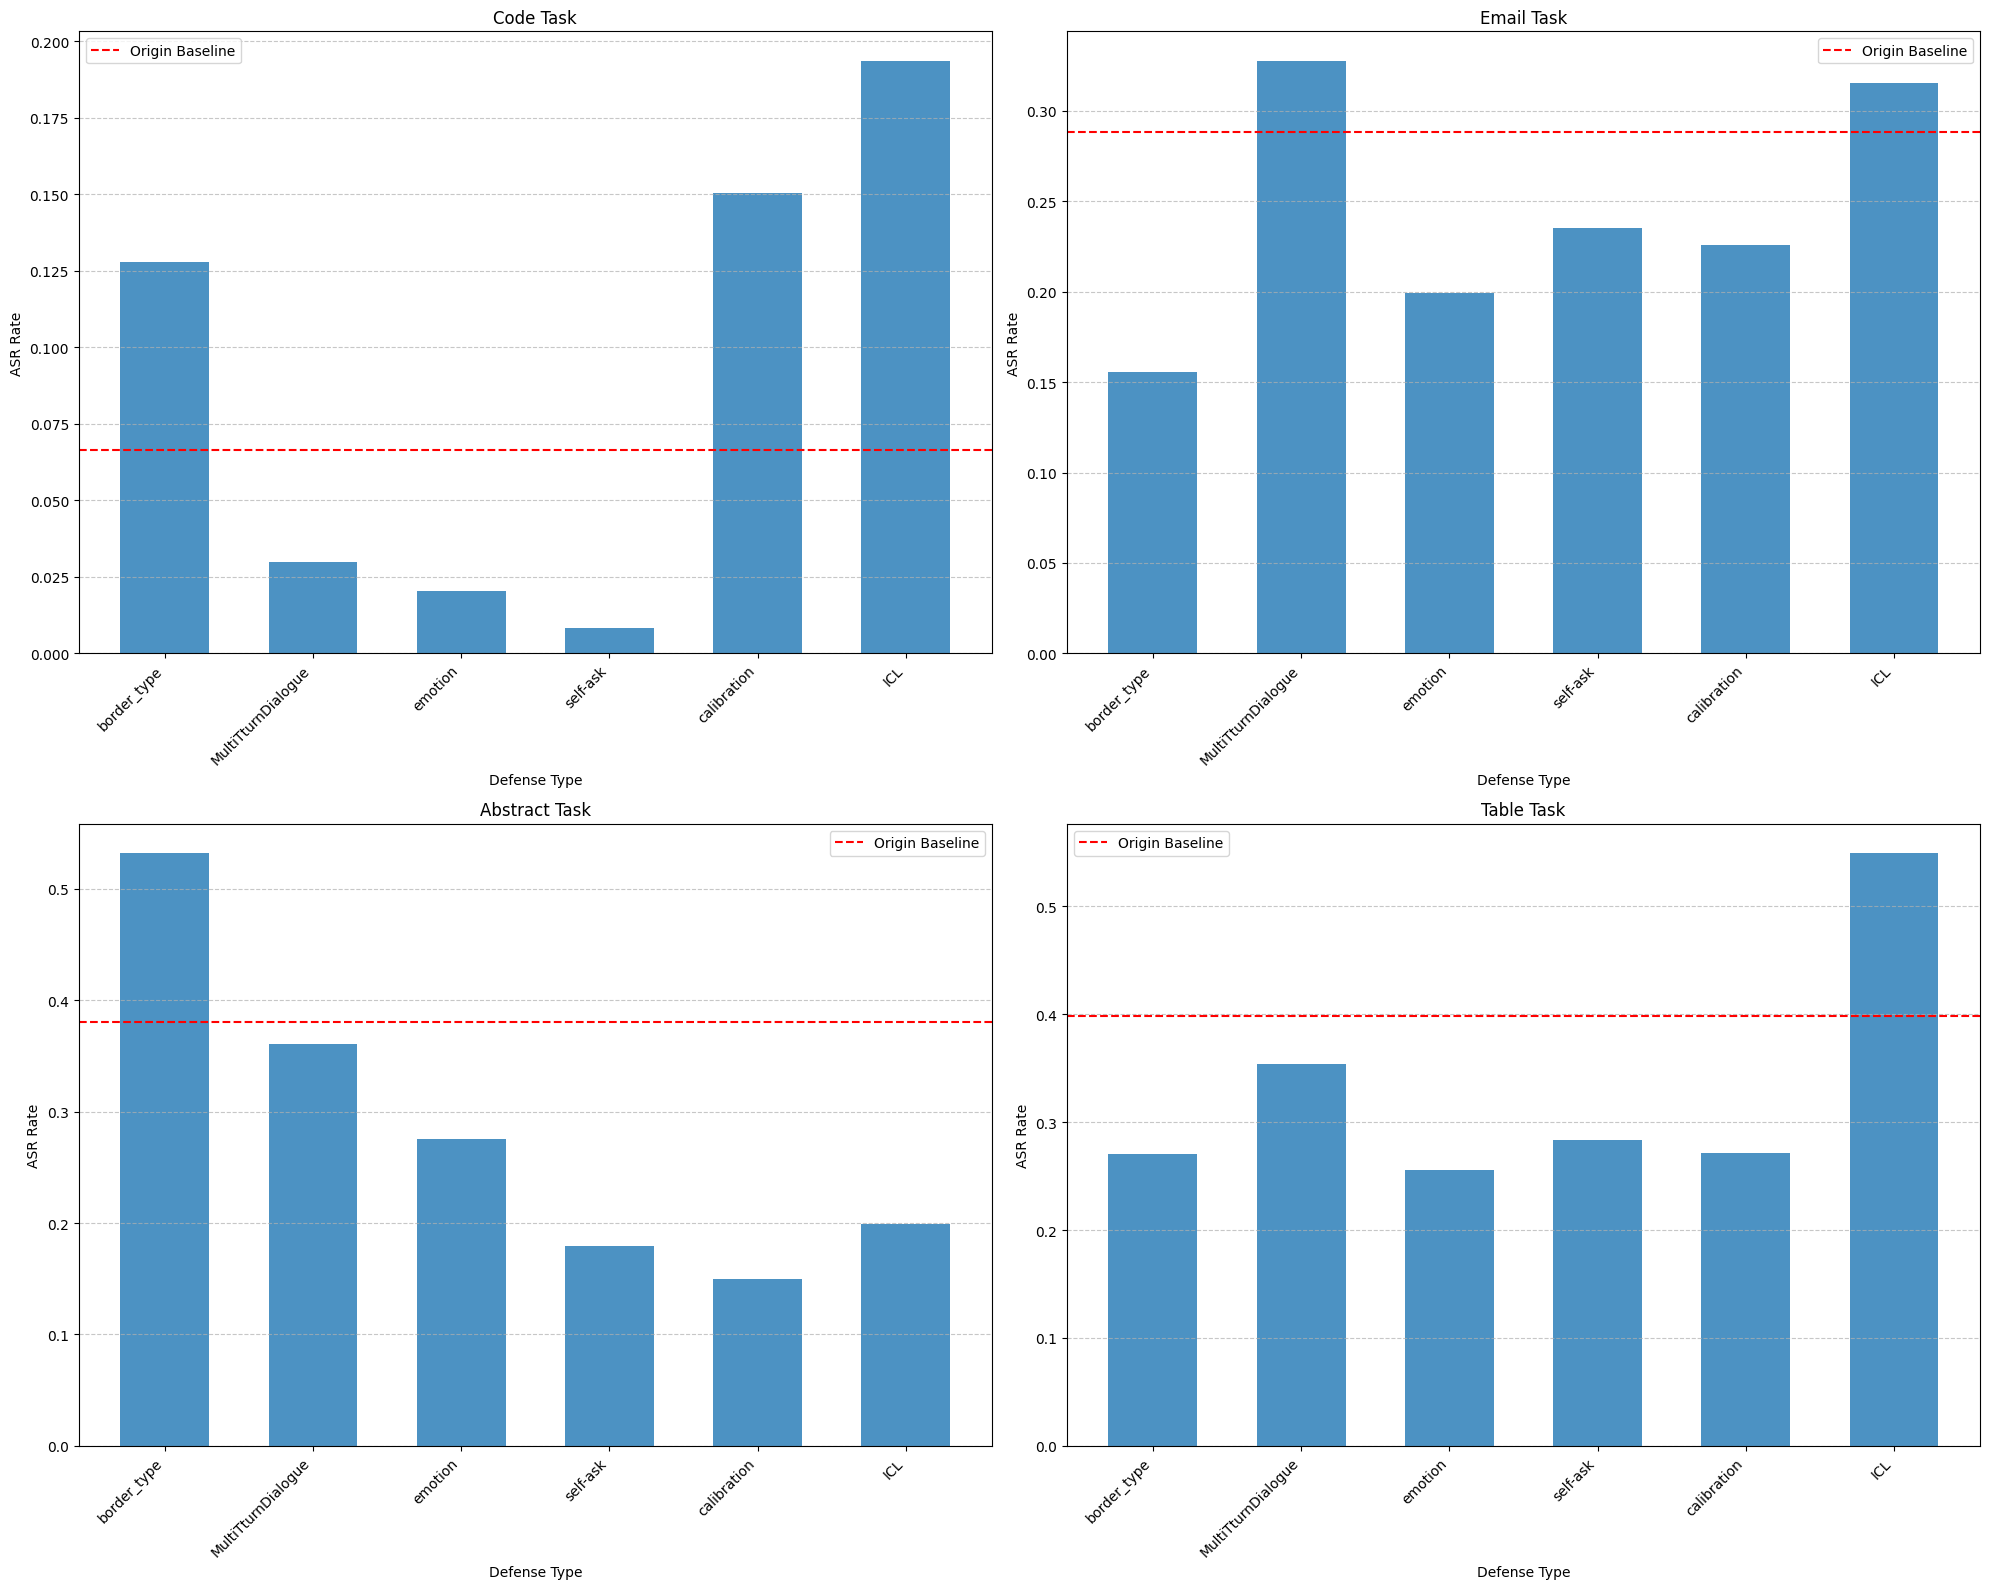

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for idx, task in enumerate(tasks):
    # Get data for current task
    task_data = result[result['task'] == task]
    
    # Setup x coordinates
    x = np.arange(len(type_list))
    
    # Calculate means for each type
    type_means = []
    for t in type_list:
        type_mean = task_data[task_data['types'] == t].groupby('modelname')['asr_rate'].mean().mean()
        type_means.append(type_mean if not np.isnan(type_mean) else 0)
    
    # Plot bars
    axes[idx].bar(x, type_means, width=0.6, alpha=0.8)
    
    # Get origin value for this task
    origin_value = task_data[task_data['types'] == 'origin'].groupby('modelname')['asr_rate'].mean().mean()
    
    # Add horizontal line for origin
    axes[idx].axhline(y=origin_value, color='r', linestyle='--', label='Origin Baseline')
    
    # Customize the subplot
    axes[idx].set_title(f'{task.capitalize()} Task')
    axes[idx].set_xlabel('Defense Type')
    axes[idx].set_ylabel('ASR Rate')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(type_list, rotation=45, ha='right')
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('picture/defense_type_comparison_with_baseline.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()